# SIR Model for Viral Marketing

In [1]:
from decimal import Decimal
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd
from tabulate import tabulate

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output

from SimCAD.configuration import Configuration
from SimCAD.configuration.utils import exo_update_per_ts, proc_trigger, bound_norm_random, \
    ep_time_step
from SimCAD.engine import ExecutionMode, ExecutionContext, Executor

In [2]:
sim_config = {
    'N': 1,
    'T': range(100)
}

seed = {}
env_processes = {}
initial_condition = {
    'Budget': float(50),
    'Ps': float(1000),
    'Pi': float(10),
    'Pr': float(0),
    'beta': float(0.05), # contact rate between S and I
    'gamma': float(0.20), # recover rate from I to R
    'timestamp': '2019-01-01 00:00:00'
}

# Parameters
epsilon = 0.03
subscription_fee = 1.0
incentive_cost = 10.0
stickiness_cost = 5.0
delta_beta = 0.1
delta_gamma = 0.1
incentive_degredation_rate = 0.02
stickiness_degredation_rate = 0.02

ts_format = '%Y-%m-%d %H:%M:%S'
t_delta = timedelta(days=0, minutes=0, seconds=1)
def time_model(step, sL, s, _input):
    y = 'timestamp'
    x = ep_time_step(s, dt_str=s['timestamp'], fromat_str=ts_format, _timedelta=t_delta)
    return (y, x)

exogenous_states = exo_update_per_ts(
    {
    'timestamp': time_model
    }
)

In [3]:
# Behaviors choose actions depending on states
# 1) increase contact rate, beta (create incentive to spread)
# 2) decrease recover rate, gamma (improve stickiness)

def add_incentive(step, sL, s):
    incentive_allocation_as_share_of_budget = 0.02
    target_beta = .1
    potential_spend = s['Budget']*incentive_allocation_as_share_of_budget
    
    potential_delta = target_beta-s['beta']
    
    cost_of_potential_delta = potential_delta * incentive_cost * s['Ps']
    if cost_of_potential_delta <= potential_spend:
        delta = potential_delta
    else:
        delta = potential_spend/(incentive_cost * s['Ps'])

    return {'delta': delta}

def add_stickiness(step, sL, s):
    stickiness_allocation_as_share_of_budget = 0.08
    target_gamma = .1
    potential_spend = s['Budget']*stickiness_allocation_as_share_of_budget
    
    potential_delta = s['gamma']-target_gamma
    
    cost_of_potential_delta = potential_delta * stickiness_cost * s['Pi']
    if cost_of_potential_delta <= potential_spend:
        delta = potential_delta
    else:
        delta = potential_spend/(stickiness_cost * s['Pi'])
    
    
    return {'delta': delta}

# def add_stickiness(step, sL, s):
#     delta = 0.0
#     potential_delta = s['gamma'] * delta_gamma
#     if (s['Pr'] > 2 * s['Pi']) and s['Budget'] > \
#         abs(potential_delta * stickiness_cost * s['Pi']):
#         delta = potential_delta
#     return {'delta': delta}

# def add_incentive(step, sL, s):
#     delta = 0.0
#     potential_delta = s['beta'] * delta_beta
#     if (s['Ps'] > 3 * s['Pi']) and s['Budget'] > \
#         abs(potential_delta * incentive_cost * s['Ps']):
#         delta = potential_delta
#     return {'delta': delta}

def dummy_behavior(step, sL, s):
    return {'delta': 0.0}

# Mechanisms incur cost to modify beta or gamma
# 1) incur cost to create incentive to spread
# 2) incur cost to improve stickiness

def incur_incentive_cost(step, sL, s, _input):
    y = 'Budget'
    x = s['Budget'] - abs(_input['delta'] * s['Ps'] * incentive_cost)
    return (y, x)

def incur_stickiness_cost(step, sL, s, _input):
    y = 'Budget'
    x = s['Budget'] - abs(_input['delta'] * s['Pi'] * stickiness_cost)
    return (y, x)

def update_beta(step, sL, s, _input):
    y = 'beta'
    x = s['beta'] + _input['delta']
    return (y, x)

def update_gamma(step, sL, s, _input):
    y = 'gamma'
    x = s['gamma'] - _input['delta']
    return (y, x)

def S_model(step, sL, s, _input):
    y = 'Ps'
    x = s['Ps'] - s['beta'] * s['Ps']
    return (y, x)

def I_model(step, sL, s, _input):
    y = 'Pi'
    x = s['Pi'] + s['beta'] * s['Ps'] - s['gamma'] * s['Pi']
    return (y, x)
    
def R_model(step, sL, s, _input):
    y = 'Pr'
    x = s['Pr'] + s['gamma'] * s['Pi']
    return (y, x)

def collect_subscription(step, sL, s, _input):
    y = 'Budget'
    x = s['Budget'] + s['Pi'] * epsilon * subscription_fee
    return (y, x)

def incentive_degrade(step, sL, s, _input):
    y = 'beta'
    x = s['beta']*(1-incentive_degredation_rate)
    return (y, x)

def stickiness_degrade(step, sL, s, _input):
    y = 'gamma'
    x = (s['gamma']+stickiness_degredation_rate)/(1+stickiness_degredation_rate)
    return (y, x)

mechanisms = {
    'spread': {
        'behaviors': {
            'dummy': dummy_behavior
        },
        'states': {
            'Ps': S_model,
            'Pi': I_model,
            'Pr': R_model,
            'Budget': collect_subscription,
            'beta': incentive_degrade,
            'gamma': stickiness_degrade 
        }      
    },
    'create_incentive': {
        'behaviors': {
            'action': add_incentive,
        },
        'states': {
            'beta': update_beta,
            'Budget': incur_incentive_cost,
        }
    },
    'improve_stickiness': {
        'behaviors': {
            'action': add_stickiness
        },
        'states': {
            'gamma': update_gamma,
            'Budget': incur_stickiness_cost,
        }
    }
}

In [4]:
def widget_handler(beta=float(0.05), gamma=float(0.20),
                   subscription_fee=float(1.0), 
                   incentive_cost=float(10.0), 
                   stickiness_cost=float(5.0)):
    initial_condition['beta'] = beta
    initial_condition['gamma'] = gamma
    subscription_fee = subscription_fee
    incentive_cost = incentive_cost
    stickiness_cost = stickiness_cost
    
    config = Configuration(
            sim_config=sim_config,
            state_dict=initial_condition,
            seed=seed,
            exogenous_states=exogenous_states,
            env_processes=env_processes,
            mechanisms=mechanisms)

    exec_mode = ExecutionMode()
    exec_context = ExecutionContext(exec_mode.single_proc)
    executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
    raw_result, tensor = executor.main()
    df = pd.DataFrame(raw_result)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format=ts_format)
    
    fig = plt.figure(figsize=(7, 14))
    
    sir = fig.add_subplot(3, 1, 1)
    sir.plot('timestamp', 'Ps', data=df, marker='', color='C0', linewidth=2)
    sir.plot('timestamp', 'Pi', data=df, marker='', color='orange', linewidth=2)
    sir.plot('timestamp', 'Pr', data=df, marker='', color='green', linewidth=2)
    sir.legend()
    
    beta_gamma = fig.add_subplot(3, 1, 2)
    beta_gamma.plot('timestamp', 'beta', data=df, marker='', color='C0', linewidth=2)
    beta_gamma.plot('timestamp', 'gamma', data=df, marker='', color='orange', linewidth=2)
    beta_gamma.legend()
    
    budget_pi = fig.add_subplot(3, 1, 3)
    budget_pi.plot('timestamp', 'Budget', data=df, marker='', color='C0', linewidth=2)
    budget_pi.plot('timestamp', 'Pi', data=df, marker='', color='orange', linewidth=2)
    budget_pi.legend()
    
    plt.show()
    
sliders = interact_manual(widget_handler, 
                beta=(0, 1, 0.01),
                gamma=(0, 1, 0.01),
                subscription_fee=(0, 10, 0.1),
                incentive_cost=(0, 20, 0.5),
                stickiness_cost=(0, 20, 0.5)
               )
sliders

interactive(children=(FloatSlider(value=0.05, description='beta', max=1.0, step=0.01), FloatSlider(value=0.2, …

<function __main__.widget_handler(beta=0.05, gamma=0.2, subscription_fee=1.0, incentive_cost=10.0, stickiness_cost=5.0)>

In [5]:
config = Configuration(
            sim_config=sim_config,
            state_dict=initial_condition,
            seed=seed,
            exogenous_states=exogenous_states,
            env_processes=env_processes,
            mechanisms=mechanisms)

from SimCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.main()
df = pd.DataFrame(raw_result)

single_proc: [<SimCAD.configuration.Configuration object at 0x11da3a550>]


,Ps,Pi,Pr
count,301.000000,301.000000,301.000000
mean,268.079410,29.445521,712.475069
std,217.194023,39.368502,253.652439
min,83.804634,1.557923,0.000000
25%,111.975410,3.720937,620.263940
50%,175.956380,10.031973,823.547145
75%,351.208484,36.182324,894.303654
max,1000.000000,142.103408,924.637443


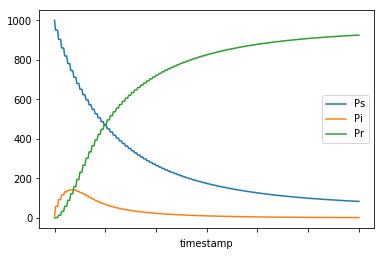

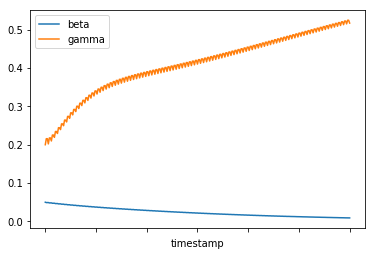

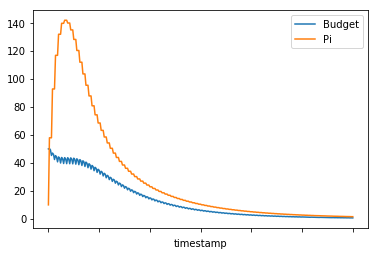

In [6]:
df.plot('timestamp', ['Ps','Pi', 'Pr'])
df.plot('timestamp', ['beta', 'gamma'])
df.plot('timestamp', ['Budget', 'Pi'])
df[['Ps','Pi', 'Pr']].describe()

In [7]:
df.head()

,Budget,Pi,Pr,Ps,beta,gamma,mech_step,run,time_step,timestamp
0,50.00000,10.0000,0.0000,1000.0000,0.050000,0.200000,0,1,0,2019-01-01 00:00:00
1,50.30000,58.0000,2.0000,950.0000,0.049000,0.215686,1,1,1,2019-01-01 00:00:01
2,49.29400,58.0000,2.0000,950.0000,0.049106,0.215686,2,1,1,2019-01-01 00:00:01
3,45.35048,58.0000,2.0000,950.0000,0.049106,0.202088,3,1,1,2019-01-01 00:00:01
4,47.09048,92.9295,13.7211,903.3494,0.048124,0.217733,1,1,2,2019-01-01 00:00:02
